# Deep Residual Networks (Resnet)

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385

https://arxiv.org/pdf/1512.03385.pdf

CNN 이 이미지 인식 분야에서 뛰어난 성능을 보여주며, 네트워크의 layer를 깊이 쌓으며 성능 향상을 이루고 있었습니다. 하지만, 실제로 layer를 깊게 쌓게 되면 gradient vanishing 문제가 생겨 성능이 더 떨어지는데 layer가 깊어지면서 역전파로 얻어지는 기울기가 너무 작거나 커지면서 문제가 생기게 되는겁니다.

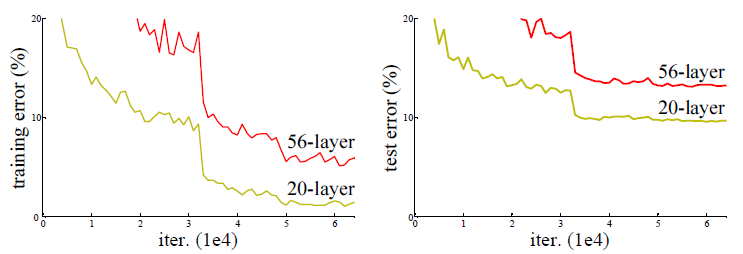

더 깊은 친구가 더 좋은 성능을 내기위한 deep residual learning (ResNet) 이 제안 되었습니다. 위에서 말한 문제를 해결하기 위해 Residual Learning 방법이 사용 되었습니다.

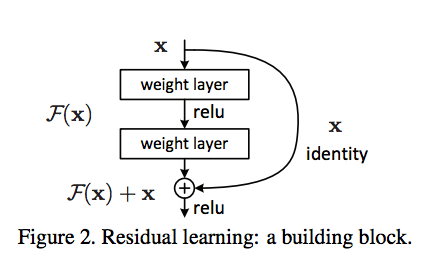

In [13]:
import os
import time
import glob
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

In [14]:
from torchsummary import summary

In [146]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # VGG의 철학을 따라 3 x 3 filter 사용
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 마찬가지로 3 x 3 filter 사용, 2번째 conv layer에서는 차원이 변하지 않음
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)


        ######################## ResNet의 핵심 부분 ######################################
        #
        # Mapping을 추가해 주어야 하는데, dimension이 변하는 부분을 고려해야 함.
        # (ResNet에서는 complexity를 유지하기 위해서 dimension이 변하는 경우에만 stride = 2로 변경)
        #
        # 1. stride == 1인 경우 : dimension이 변하지 않음 -> identity mapping 사용
        # 2. stride != 1인 경우 : dimension이 변하는 경우이므로 identity mapping을 사용할 수 없음
        #                        -> 1 x 1 convolution을 활용하여 차원을 맞추어 줌.
        #

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        # 실제 논문에서 사용한 방식과 거의 유사함 (shortcut 위치 등)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [168]:
#Optional
class BottleNeck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleNeck, self).__init__()

        final_channels = out_channels * self.expansion

        # 1*1 filter를 이용해서 차원수를 감소시킴
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 차원 수가 줄어든 feature map에 3*3 filter를 적용해서 feature 추출
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # out_channel로 맞춰줌
        self.conv3 = nn.Conv2d(out_channels, final_channels, kernel_size=1, stride=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(final_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != final_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, final_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(final_channels)
            )


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)

        return out

In [169]:
# Basic Block을 여러 개 붙여서 ResNet을 정의
# 앞서 정의한 Basic Block을 _make_layer() method에 넘겨서 이어붙이는 구조
# num_blocks에 [2, 2, 2, 2]를 넘겨주면 18-layer가 됨 (conv1 + 4 + 4 + 4 + 4 + FC)

class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=20, init_weights=True):
        # block: ResidualBlock or Bottleneck
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)


    def _make_layer(self, block, out_channels, num_blocks, stride):
        # 첫 번째 conv에서만 stride를 통해 차원을 변경해줄 수 있도록 지정
        # num_blocks = 3이라고 하면 building block 3개를 이어붙이므로 6개의 layer가 생기는 것
        # (단, 1번째 block의 conv1에만 stride를 적용하고 나머지는 1)
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)  # FC 레이어
        return x

전체 구조

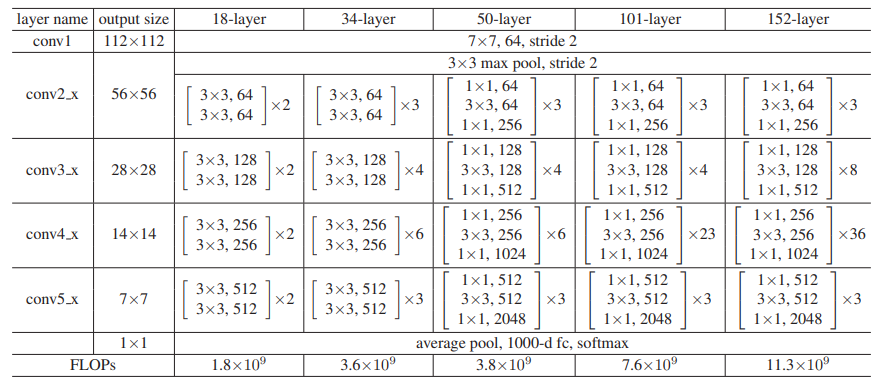

In [170]:
def resnet18():
    return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
    return ResNet(BasicBlock, [3,4,6,3])

def resnet50():
    return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
    return ResNet(BottleNeck, [3,4,23,3])

def resnet152():
    return ResNet(BottleNeck, [3,8,36,3])


In [171]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50().to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output.size())

torch.Size([3, 20])


In [172]:
 # CIFAR10

import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [173]:
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [174]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = resnet50() #다른 layer로 수정
net = net.to(device)
net = torch.nn.DataParallel(net)

learning_rate = 0.1
file_name = 'resnet18_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)


def train(epoch):
    print("------------------------------------------------------------")
    print('\nEpoch %d (train)' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            print('\nBatch', str(batch_idx))
            print('Accuracy (train):', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Loss:', loss.item())

    print('\nTotal accuarcy (train):', 100. * correct / total)
    print('Total loss:', train_loss)


def test(epoch):
    print('\nEpoch: %d (test)' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nAccuracy (test):', 100. * correct / total)
    print('Test average loss:', loss / total)

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')


def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [175]:
# for epoch in range(0, 200):
for epoch in range(0, 2):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)

------------------------------------------------------------

Epoch 0 (train)

Batch 0
Accuracy (train): 0.109375
Loss: 2.9807627201080322

Batch 100
Accuracy (train): 0.1484375
Loss: 3.571847677230835

Batch 200
Accuracy (train): 0.2109375
Loss: 4.819058418273926

Batch 300
Accuracy (train): 0.1640625
Loss: 2.4925999641418457

Total accuarcy (train): 16.542
Total loss: 1549.870488166809

Epoch: 0 (test)

Accuracy (test): 18.65
Test average loss: 0.02238519015312195
Model Saved!
------------------------------------------------------------

Epoch 1 (train)

Batch 0
Accuracy (train): 0.1640625
Loss: 2.124788522720337

Batch 100
Accuracy (train): 0.21875
Loss: 2.256650447845459

Batch 200
Accuracy (train): 0.25
Loss: 1.9336670637130737

Batch 300
Accuracy (train): 0.25
Loss: 1.9878637790679932

Total accuarcy (train): 24.556
Total loss: 797.4512901306152

Epoch: 1 (test)

Accuracy (test): 28.81
Test average loss: 0.01883049581050873
Model Saved!


## Assignment

1. 18-layer의 ResNet을 구현한 코드의 구조를 활용하거나, 필요하다면 새로운 코드를 추가하여 다른 layer의 ResNet을 구현해 보세요. 돌리는데 시간이 오래 걸릴 수 있으니 학습이 되는지만 확인하고 끝까지 training 진행하지 않아도 됩니다.(resnet def은 모든 레이어에 대해서 해주고, 돌리는 것만 하나 정해서 진행)

2. ResNet은 점점 더 깊은 모델을 만드는 과정에서 생긴 문제점을 해결하기 위해서 나온 모델입니다. 그렇다면 더 깊게 layer를 쌓았을 때 일반적으로 성능 관점에서 기대할 수 있는 장점이 무엇인지 서술해 보세요.

3. ResNet의 주요 아이디어 중 하나는 어떤 형태의 블록을 사용하는 것인가요? 그 블록의 구조를 설명하세요.

4. **[Optional]** 위의 코드에서는 2개의 convolution layer와 identity mapping layer를 묶어서 하나의 BasicBlock을 만들고, 이를 여러 개 쌓아서 18-layer의 ResNet을 구현하였습니다. 그러나 50-layer 이상으로 ResNet이 깊어지면 parameter의 수가 많아지기 때문에 BasicBlock 대신 **Bottleneck Block** 을 이용하게 됩니다. 아래의 그림을 참고하여 Bottleneck block class를 새로 정의하고, 이를 _make_layer() 함수에 넘겨주는 방식으로 50-layer의 ResNet을 구현해 보세요. (왼쪽 그림이 BasicBlock, 오른쪽 그림이 BottleNeck Block)

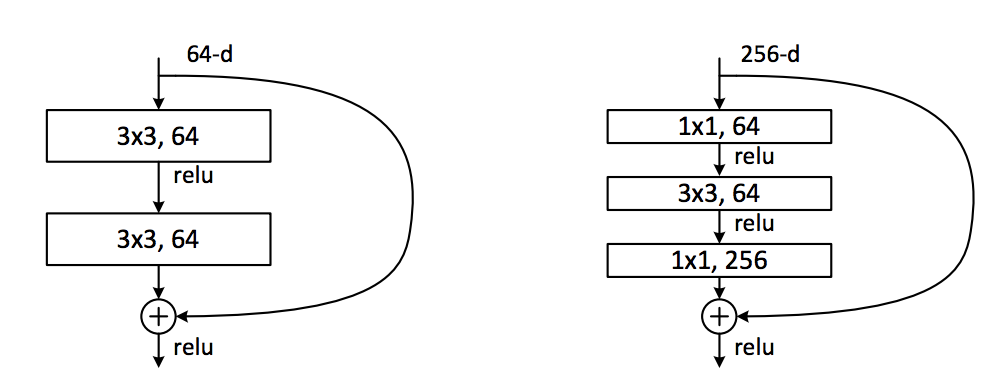

1. layer-50 model을 실행했습니다. <dr>
2. Layer를 깊게 쌓으면 보다 복잡한 패턴을 학습하는 것이 가능해집니다. 예를 들어 computer vision에서 이용하는 CNN의 경우, input layer에 가까운 layer는 edge와 같이 간단한 특징을 인식합니다. 반면, output layer과 가까워질수록 더 복잡한 구성 요소들을 인식합니다. 즉, Layer를 깊게 쌓을수록 더 복잡한 구성요소를 인식하는 것이 가능해지고, 그 결과 더 정확한 예측이 가능하게 됩니다. 다만, 깊게 쌓을수록 parameter의 개수가 증가하게 되므로 학습 비용이 비싸지는 등의 문제가 생기기 때문에 다양한 기술이 필요합니다. <dr>
3. Residual block을 활용하는 방법입니다. 이 블럭은 네트워크의 일부 레이어를 건너뛰는 방법으로, 해당 블럭에 들어온 input을 convolution layer를 거쳐 만든 값과 input 그 자체를 더해줍니다. <dr>
4. Bottleneck Block의 구현을 마무리 했습니다.